# Set the background stratification, mean zonal velocity, and layer depths for QGN code
Note that the QGN code ignores the total depth used for plotting in this notebook. It reads the layer thicknesses from `H.dat` then re-scales the total depth to the value prescribed in `parameters.f90`.
If you change total depth within this notebook it will have absolutely no effect on the QGN code; it will only change the plots here. Also note that the number of layers is set in `parameters.f90`. The value used here has to match the value set in `parameters.f90` or there will be errors.

In [1]:
import numpy as np
import scipy.integrate as integrate
import scipy.optimize as optimize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# In this cell set the number of layers and the choice of stretched vertical coordinate using alpha
nz = 32 # Number of layers
alpha = 1 # choice of grid spacing. alpha=0 is equispaced, alpha=2 is equispaced in density, alpha=1 is halfway between. alpha=1 is a good choice for a variety of reasons - paper in prep.
H_tot = 4800 # Total depth in meters. The QGN code sets this in parameters.f90 and will ignore any value entered here. This value is just for plotting.

In [3]:
# In this cell define N^2(z)/f^2.
# Note the convention that z=0 is at the bottom and z=H is at the top; compare this to the alternative convention
# (not adopted here) that z=0 at the top and z=-H at the bottom.
def N2(t):
    #return 1 + 0*t
    return ( 1 + 9*t +50*np.exp(-75*(t - 0.8)**2) )**2

# def N2(t):
#     #return 1 + 0*t
#     return np.ones(len(t))
# def N2(t):
#     return np.exp(8*t)

In [4]:
# This cell gets the layer spacing. These use a total depth of 1.
SS = lambda t: np.sqrt(N2(t)) ** alpha
normalization_constant = integrate.quad(SS,0,1)[0]
z = np.zeros(nz+1)
z[nz] = 1
for i in range(1,nz):
    z[i] = optimize.fsolve(lambda t: integrate.quad(SS,0,t)[0] - normalization_constant*i/nz,i/nz)
h = z[1:]-z[:-1]
zc = (z[:-1]+z[1:])/2 # height of cell centers

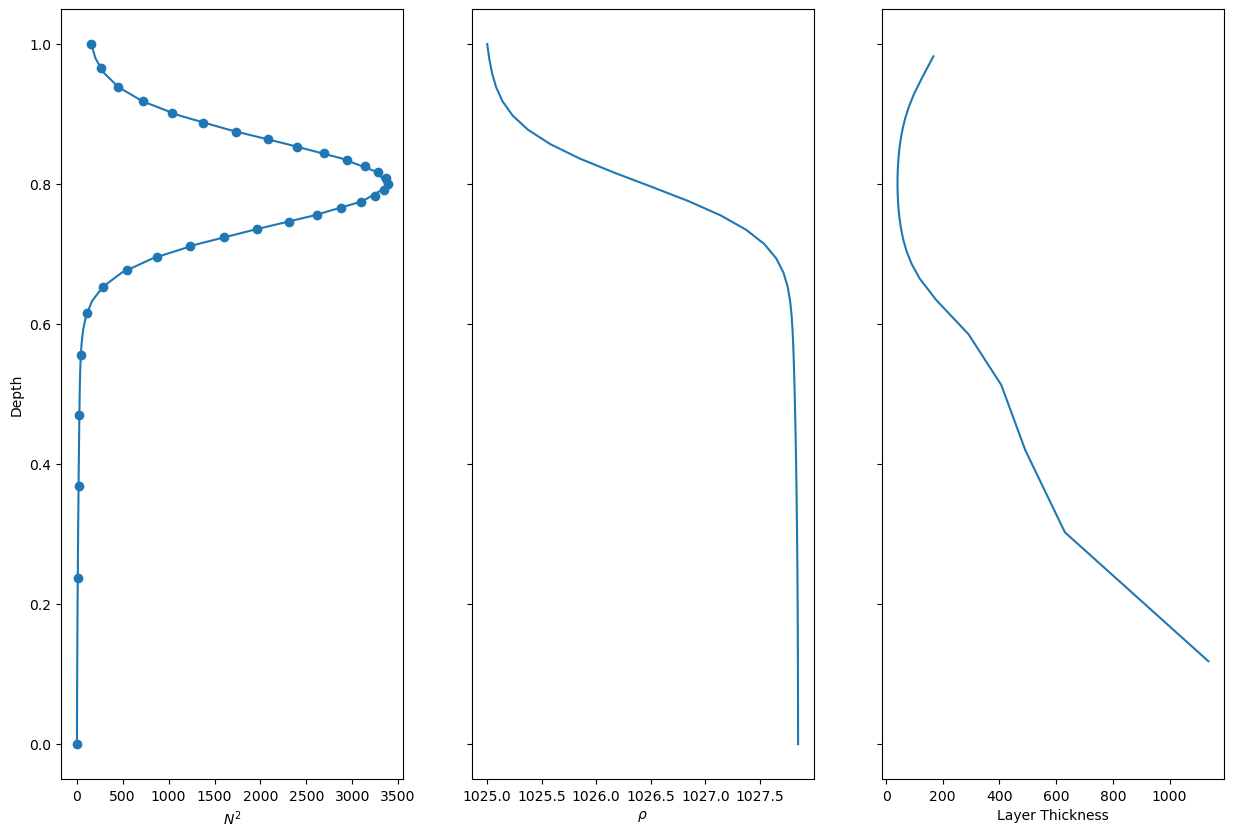

In [5]:
fig, ax = plt.subplots(1,3,figsize=(15,10),sharey=True)

zs = np.linspace(0,1)
rho = np.zeros(len(zs))
for i in range(0,len(zs)):
    rho[i],_ =  integrate.quad(N2,zs[i],1) # This computes g (rho-rho_top)/(f0^2 * rho0 * H)

ax[0].plot(N2(zs),zs) # Plots N^2(z)
ax[1].plot((1E-8*1030*H_tot/9.8)*rho + 1025,zs) # This plots a credibly-scaled rho profile
ax[0].scatter(N2(z),z)
ax[2].plot(H_tot*h/sum(h),zc)

ax[0].set_ylabel('Depth')
ax[0].set_xlabel(r'$N^2$')
ax[1].set_xlabel(r'$\rho$')
ax[2].set_xlabel('Layer Thickness');

In [6]:
# To get the mean flow profiles we use the first baroclinic mode and an 'ocean-Charney' profile.
# Both of these require the QG stretching matrix, which we now construct.
# The construction is based on a "level" rather than a "layer" discretization, though there is an equivalence. For details see Grooms & Nadeau, Fluids 2016.
DS = np.diag(1/N2(z[1:-1]))
D0 = np.zeros((nz-1,nz))
D0[:,:-1] = 2*np.diag(1/(h[:-1]+h[1:]))
D0[:,1:] = D0[:,1:] - 2*np.diag(1/(h[:-1]+h[1:]))
D = DS@D0
L = (1/h)*(np.vstack((np.zeros((1,nz)),D))-np.vstack((D,np.zeros((1,nz)))))
L = L.T # Use C/Python's indexing convention rather than Fortran/Matlab.

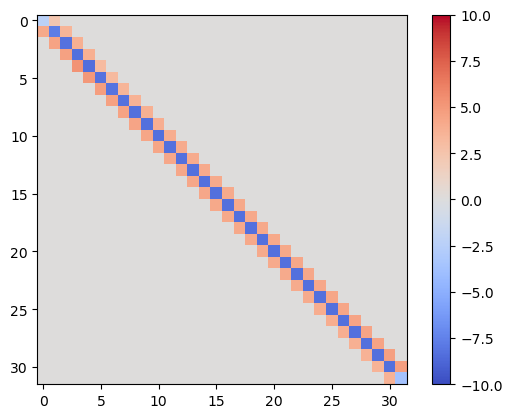

In [7]:
plt.imshow(L,cmap=plt.cm.coolwarm,vmin=-10,vmax=10)
plt.colorbar();

In [8]:
# This cell gets the baroclinic modes and the eigenvalues of the stretching matrix
(vals,vecs) = np.linalg.eig(L)
ind = np.argsort(-vals)
first_bc_mode = vecs[:,ind[1]]
first_bc_mode /= first_bc_mode[-1] # sign convention and normalization are that the first baroclinic mode is 1 at the top

[ 1.17850461  1.18562598  1.19418118  1.20253533  1.21544446  1.23346678
  1.25565349  1.28163344  1.31107111  1.3439421   1.38122609  1.42457319
  1.47523922  1.5340897   1.60211206  1.68062544  1.77120148  1.87556469
  1.99605704  2.13730565  2.30789665  2.51989835  2.78819924  3.13156939
  3.57200709  4.12926761  4.85713179  5.9871989   8.08088825 13.02638677
 40.37003515         nan]


/tmp/ipykernel_6370/3934435482.py:2: RuntimeWarning: invalid value encountered in sqrt
  print(H_tot*np.sort(1/np.sqrt(-vals))/1E3)
/tmp/ipykernel_6370/3934435482.py:3: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(H_tot*np.sort(1/np.sqrt(-vals))/1E3);


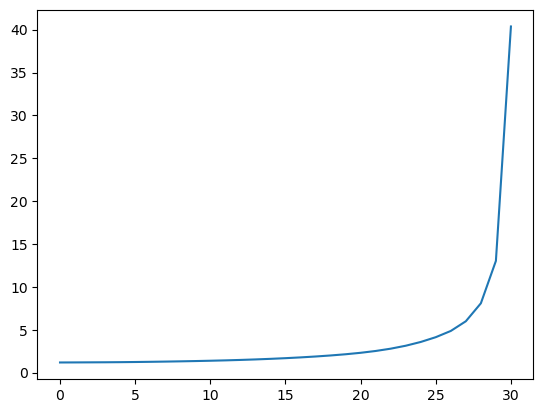

In [9]:
# This cell prints and plots the deformation radii in units of km. One of them may be nan or inf because of the barotropic mode. Roundoff error prevents computing the eigenvalue 0 exactly.
print(H_tot*np.sort(1/np.sqrt(-vals))/1E3)
plt.plot(H_tot*np.sort(1/np.sqrt(-vals))/1E3);

In [10]:
# Next we need the ocean-Charney profile. It is defined so that the mean PV gradient is a constant, and u=u'=0 at the bottom.
L_oc = L[:-1,1:]
oc_profile = np.linalg.solve(L_oc,np.ones(nz-1))
oc_profile = np.concatenate((np.zeros(1),oc_profile))
oc_profile /= oc_profile[-1] # sign convention and normalization are that the ocean-Charney profile is 1 at the top

In [11]:
# Now set the mean velocity as a linear combination of the first baroclinic mode and the ocean-Charney profile:
u_bar = 0.22*first_bc_mode - 0.08*oc_profile

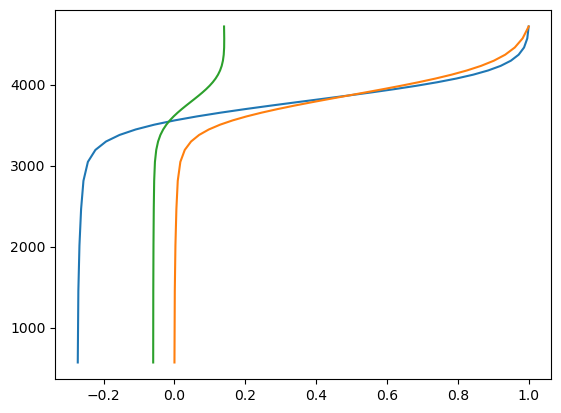

In [12]:
# Plot the profiles.
plt.plot(vecs[:,ind[1]],H_tot*zc,oc_profile,H_tot*zc,u_bar,H_tot*zc)

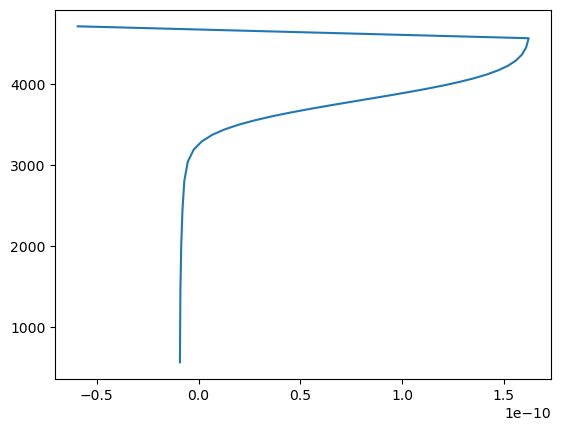

In [13]:
# Also plot the mean PV gradient. It needs to change sign at least once in order for the system to be baroclinically unstable.
# You also need to include planetary beta when assessing whether the mean PV gradient changes sign. This cell uses beta=2E-11.
# Note that the ocean-Charney profile appears to have a non-constant PV gradient. What is happening is that
# the 2nd order discretization can't distinguish between a PV gradient and a surface buoyancy gradient in the top layer.
# The ocean-Charney profile has a constant PV gradient and a nonzero surface buoyancy gradient.
qy_bar = -(1/H_tot**2)*L@u_bar # The factor of 1/H_tot**2 scales for total depth, which is needed only to compare to planetary beta.
plt.plot(qy_bar + 2.E-11,H_tot*zc)

In [14]:
# Now write 
#  (i)   the stratification function S = f^2/N^2(z) evaluated at interface heights
#  (ii)  the layer thicknesses, and
#  (iii) the mean flow profile
# The indexing convention in the QGN model is left-handed, like most ocean models, 
# i.e. the first index is at the top of the ocean and the last index is at the bottom of the ocean.
S = np.zeros(nz+1)
for i in range(nz+1):
    S[nz-i] = 1/N2(z[i])

In [15]:
S.tofile("S.dat")

np.flip(h).tofile("H.dat")

np.flip(zc).tofile("zc.dat")

np.flip(u_bar).tofile("UBar.dat")